# Inventory Reblancing Using Minimum Cost Flow and Travelling Salesman Problem. 

We have have introduced a method of estimating supply and demand at particular bikestations at the end of 24 hour and at the end of a week in [Estimating Demand and Supply ](./Estimating_Demand_and_Supply.ipynb). 

We [mapped this data](./Visualize_Supply_and_Demand_Using_Maps.ipynb) using folium and drew some useful insights on how the flow of demand and [supply changes in central london](./Inventory_Rebalancing_With_MCF_and_TSP.ipynb).


The next stage of the project will look at reblancing the inventory at particular bike stations. At the beginning of a 24 hour day the net demand at all stations is 0. At the end of 24 hours bikes have moved between particular stations. The stations will either have a negative value indicating excess supply, or a positive value indicating excess demand. Companies running these stations usually used capacitated vehicles to exchange bikes between stations. We will refer to this as the reblancing process. Its aim is exchange bikes between stations at a minimum cost, with the end result being that all the stations net demand returns to 0. We can define the cost in this case as the straight line distance between stations. This is heuristic value but is a good starting point. 

## Minimum Cost Flow Problem for determining exchanges

At the end of the day we have bike stations with demand and supply. Because of the way we formulated demand and supply, we know that the sum of all the demand in the network is 0. If $N$ is the list of all the bikestations in the network and $d_n$ is there demand value, then.


$$\sum{d_n} = 0, n \in N$$ 

We can split the nodes in $N$ into three types, $d>0$, $d<0$ and $d=0$. Nodes where $d=0$ are irrelevant as they do not need rebalancing. They can be removed from the problem. 

### Bipartite Graph Formulation
We want to match nodes in with $d<0$ or supply nodes to nodes where $d>0$ which are demand nodes. This can be formulated as a bipartite graph. We would have a set $S$ containing only supply nodes and a set $D$ containing only demand nodes. The lengths of the edges of nodes between sets $S$ and $D$ would be the straight line distance between the bike stations. We can create such a graph by processing the demand over a single day. 



First we get data on bikestations and trips. We then filter out all unique dates with a starting trip and pick an arbitrary one to operate on. We also  filter out trips to/from stations that we do not have locational data on. 

In [2]:
import pandas as pd 
import os 
from ipynb.fs.full.Estimating_Demand_and_Supply import  processTripsOverTime
import geopandas as gpd
import pyproj 
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt

bikeStations = pd.read_pickle(os.path.join(os.getcwd(),r'pickles\bikeStations.pkl'))
trips = pd.read_pickle(os.path.join(os.getcwd(),r'pickles\trips.pkl'))
unq = trips["Start Date"].map(pd.Timestamp.date).unique()
trips = trips[trips['StartStation Id'].isin(bikeStations['id'].astype(np.int64).tolist())]
trips = trips[trips['EndStation Id'].isin(bikeStations['id'].astype(np.int64).tolist())]
date = unq[0]
date

datetime.date(2018, 3, 10)

Next we use the same function that we used for estimating the demand over a particular timeframe to count the demand over a particular day. First we apply a mask to our trip to filter out trips only occuring on our specified day. In this way the trips frame will only contain relevant dates so our processTripsOverTime function will be returning returning the exact demand and supply at the end of that paricular day.

We end up with the exact number (Negative Value) /lack of bikes (Positive Value) at paricular stations at the end of the given date. 




In [3]:
dateMask = (trips['Start Date'].dt.year == date.year) & (trips['Start Date'].dt.month == date.month) & (trips['End Date'].dt.day == date.day)
trips = trips[dateMask]
bikeStations = processTripsOverTime(trips,bikeStations,1,range(0,24),"D")
bikeStations.head()


,$type,id,url,commonName,placeType,additionalProperties,children,childrenUrls,lat,lon,demand
0,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",84,/Place/BikePoints_84,"Breams Buildings, Holborn",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.515937,-0.111778,-3.0
1,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",85,/Place/BikePoints_85,"Tanner Street, Bermondsey",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.500647,-0.078600,-12.0
2,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",86,/Place/BikePoints_86,"Sancroft Street, Vauxhall",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.489479,-0.115156,12.0
3,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",87,/Place/BikePoints_87,"Devonshire Square, Liverpool Street",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.516468,-0.079684,-3.0
4,"Tfl.Api.Presentation.Entities.Place, Tfl.Api.P...",88,/Place/BikePoints_88,"Bayley Street , Bloomsbury",BikePoint,[{'$type': 'Tfl.Api.Presentation.Entities.Addi...,[],[],51.518587,-0.132053,-6.0


We want to calculate straight line distances between the stations so we will conver the bikeStations to a GeoDataFrame. We will use the british national grid coordinate system for more accurate measurements. 

In [4]:
bikeStations = gpd.GeoDataFrame(bikeStations,crs="EPSG:4326",geometry=gpd.points_from_xy(bikeStations.lon, bikeStations.lat) )
bikeStations = bikeStations.to_crs(crs = pyproj.CRS("EPSG:27700"))

Next we split our bike stations into the two previously described sets "S" and "D". Notice that the sum of the supply is equal to the negation of the sum of the demand. This corresponds to previously defined constraint. 

$$\sum{d_n} = 0, n \in N$$ 

In [5]:
supply = bikeStations[ bikeStations['demand'] <0]
demand = bikeStations [ bikeStations['demand'] > 0]
print(supply['demand'].sum(),demand['demand'].sum())


-2081.0 2081.0


We want to create edges between all supply and demand nodes. We create an arrays to hold these values, we define the capacity of the edge as the the demand at the supply node. We convert these values to a DataFrame.

In [6]:
startEdge = []
startGeo = [] 
endEdge = [] 
endGeo = []
capacity = [] 

for index , row in supply.iterrows():
    for i , r in demand.iterrows():
        if row['id'] != r['id']:
            startEdge.append(row['id'])
            startGeo.append(row.geometry)
            endEdge.append(r['id'])
            endGeo.append(r.geometry)
            capacity.append(abs(row['demand']))
d = {'edgeStart' : startEdge,'startPoint': gpd.GeoSeries(startGeo),'edgeEnd' :endEdge,'endPoint':gpd.GeoSeries(endGeo),'capacity':capacity}
edges = pd.DataFrame(data=d)
edges.head()

,edgeStart,startPoint,edgeEnd,endPoint,capacity
0,84,POINT (531114.334 181357.772),86,POINT (530955.759 178409.583),3.0
1,84,POINT (531114.334 181357.772),89,POINT (530271.002 182483.654),3.0
2,84,POINT (531114.334 181357.772),90,POINT (529165.237 183208.630),3.0
3,84,POINT (531114.334 181357.772),91,POINT (531231.229 178884.816),3.0
4,84,POINT (531114.334 181357.772),93,POINT (531252.235 183416.694),3.0


Next we want to associate the weight of the edge with the straight line distance between the two points. We use GeoPandas data manipulation to acheive this. We conver the start point and edge points to GeoSeries objects and apply the distance function elementwise to obtain the straight line distances. 

In [7]:
x =  gpd.GeoSeries(edges['startPoint'],crs=pyproj.CRS("EPSG:27700"))
y = gpd.GeoSeries(edges['endPoint'],crs= pyproj.CRS("EPSG:27700"))
distances = x.distance(y,align=False)
edges['weight'] = distances
edges =  edges.drop("startPoint", axis=1)
edges = edges.drop("endPoint", axis=1)
edges

,edgeStart,edgeEnd,capacity,weight
0,84,86,3.0,2952.450630
1,84,89,3.0,1406.704811
2,84,90,3.0,2687.871323
3,84,91,3.0,2475.717367
4,84,93,3.0,2063.534929
...,...,...,...,...
127375,693,689,5.0,2491.472894
127376,693,690,5.0,4456.059404
127377,693,692,5.0,15554.747095
127378,693,694,5.0,456.985734


###  Minimum Cost Flow Specification

We have created a bipartite graph consisting of demand and supply nodes. 

We want to send bikes from the supply nodes to the demand nodes in such a way that our original constraint of 

$$\sum{d_n} = 0, n \in N$$ 


is satisfied at an estimated minimum cost. One way to do this is to reformulate the problem as a minimum cost flow problem. 
The minimum cost flow problem takes a directed graph with a sink and source vertex and sends flow from the source to sink at at a minimum cost so that the demand and supply are satisfied. The problem can be stated as follows 

$$

\min{a(u,v) \times f(u,v)} 

$$

With the following constraints

$$ f(u,v) \le c(u,v) $$
$$ \sum_{w \in V} f(u,w) = 0 \textrm{  for all } u \neq{s,t} $$
$$ \sum_{w \in V} f(s,w) = d  \textrm{  and  } \sum_{w \in V} f(w,t) =d $$

Where 
* $a$ is the cost of sending flow along a particular edge
* $f$ is the flow along a particular edge
* $s,t$ are the source and sink nodes respectively 
* $d$ is the supply/demand at the source/sink 
* $V$ is the set of all vertices 

### Transforming bipartite network into minimum cost flow problem 
Lets start by creating a small bipartite network which simulates our supply/demand problem on a smaller scaleand show how we could reformulate it into a minimum cost flow problem. 











{('3', '6'): Text(0.25, 0.5625, '5'),
 ('3', '5'): Text(0.25, 0.0, '8'),
 ('2', '6'): Text(0.25, 0.375, '6'),
 ('2', '5'): Text(0.25, -0.1875, '7'),
 ('1', '6'): Text(0.25, 0.0, '8'),
 ('1', '5'): Text(0.25, -0.5625, '5'),
 ('4', '6'): Text(0.25, 0.1875, '7'),
 ('4', '5'): Text(0.25, -0.375, '6')}

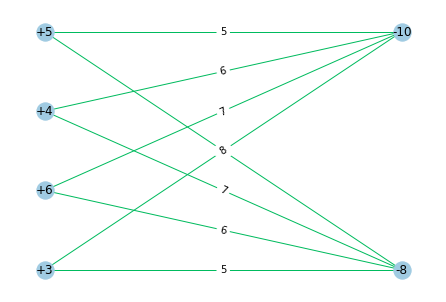

In [42]:
supplyId = ['1','2','3','4']
demandId = ['5','6']
imbalance = [5.0,0.0,0.0,0.0,0.0,-5]
from pyvis.network import Network
weights = [1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0]
capacity = [5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0]
edges = []
for i,n in enumerate(supplyId):
    for j in demandId:
        edges.append((n,j))
B = nx.Graph()
B.add_nodes_from(supplyId,bipartite= 0, label = 'supply')
B.add_nodes_from(demandId,bipartite = 1,label ='demand')
B.add_edges_from(edges)
pos = nx.bipartite_layout(B, supplyId)

d = {'3':'+5','2':'+4','4':'+6','1':'+3','6':'-10','5':'-8'}
d_edges = {('3','6'):5,('3','5'):8,('2','6'):6,('2','5'):7,('1','6'):'8',('1','5'):5,('4','6'):7,('4','5'):6}
nx.draw(B,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues)
nx.draw_networkx_labels(B,pos,d)
nx.draw_networkx_edge_labels(B,pos,d_edges)


On the left we have supply nodes and on the right we have demand nodes. Note we have arbiratily chosen to have more supply nodes than demand nodes.The model will work for any number of supply nodes or demand nodes since the net supply/demand in the network will be 0. We also add some arbitary weights to the edge. In a real graph this would be the straight line distance. 

We need to convert this to a minimum cost flow problem. In order to do this we will add a source and a sink. The source and sink each with a total supply and demand of all the bikes in the network. We will then add edges from the source nodes to the supply nodes with a capacity of the supply at that node and a cost of 0. We add edges from the demand node to the sink node where the capacity is the demand at the demand nodes and the cost is 0. Finally we transform the edges between supply and demand nodes so that they have have a capacity of the supply node. 

Lets take a look at what this transformation would look like

{('-1', '3'): Text(-0.5384615384615385, -0.15384615384615385, '(6,0)'),
 ('-1', '2'): Text(-0.5384615384615385, 0.15384615384615385, '(4,0)'),
 ('-1', '1'): Text(-0.5384615384615385, 0.46153846153846156, '(5,0)'),
 ('-1', '4'): Text(-0.5384615384615385, -0.46153846153846156, '(3,0)'),
 ('5', '-2'): Text(0.6923076923076923, 0.15384615384615385, '(10,0)'),
 ('6', '-2'): Text(0.6923076923076923, -0.15384615384615385, '(8,0)')}

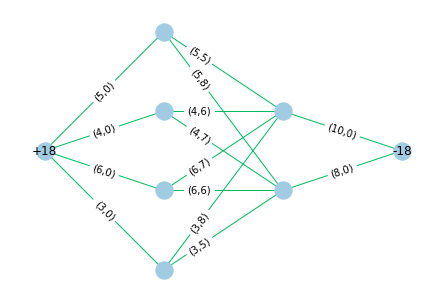

In [62]:
supplyId = ['1','2','3','4']
demandId = ['5','6']
sinkId = ['-2']
sourceId = ['-1']

edges = []
for i,n in enumerate(supplyId):
    edges.append(('-1',n))
    for j in demandId:
        edges.append((n,j))
        
for i,n in enumerate(demandId):
    edges.append((n,'-2'))
B = nx.Graph()
B.add_nodes_from(supplyId,level= 1, label = 'supply')
B.add_nodes_from(demandId,level = 2,label ='demand')
B.add_nodes_from(sourceId,level = 0)
B.add_nodes_from(sinkId,level = 3 )
B.add_edges_from(edges)
pos = nx.multipartite_layout(B, subset_key="level")

d = {'-1':'+18','-2':'-18'}
d_edges = {('3','6'):'(6,6)',('3','5'):'(6,7)',('2','6'):'(4,7)',('2','5'):'(4,6)',('1','6'):'(5,8)',('1','5'):'(5,5)',('4','6'):'(3,5)',('4','5'):'(3,8)'}
source_sink_to_edges = {('-1','3'):'(6,0)',('-1','2'):'(4,0)',('-1','1'):'(5,0)',('-1','4'):'(3,0)',('5','-2'):'(10,0)',('6','-2'):'(8,0)'}

nx.draw(B,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues)
nx.draw_networkx_labels(B,pos,d)
nx.draw_networkx_edge_labels(B,pos,d_edges,label_pos=0.7)
nx.draw_networkx_edge_labels(B,pos,source_sink_to_edges)


Each of the edges has an attribute in the form of (capacity,cost)

We have creates a transformation procedure that converts our bipartite demand/supply nodes to a minimum cost flow problem. 
The generalized procedure is as follows 

* Create Source and Sink. Add imbalance to Source as sum of demand at all supply nodes. Add imbalance to Sink as sum of demand at all demand nodes. 
* Create Edges from Source to supply nodes with capacity of supply at node and cost per flow 0 
* Create edges from Demand nodes to sink nodes with capacity of demand at node and cost per flow 0 
* Create edges from each supply node to each demand node with capacity of supply at node and cost of straight line distance between nodes. 


 We can now solve this as a minimum cost flow problem. In this case the objective function is would be a heuristic for finding a cheapest assignment of edges  since minimizing cost $\times$ flow does not accurate reflect the cost of repositioning bikes. The cost does not increase exponentially the more bikes we send along it. The solver would still give us a feasible reassignment at estimated lowest cost. 

 Lets apply this transformation to the bipartite network we formulated above. 